# Orbitrap data treatment 
    Inputs: a series of .isox files and a sequence.csv file, for a series of Vanquish injections
    Outputs: an excel file compiling all the results from each step of calculation:
        - block averages
        - bracketed deltas for each sample and a statistical summary
        - statistical summary of internationally referenced deltas

## 1. Data and sequence import and pretreatment  
#### a. Import .isox data and sequence file from pathdata  
#### b. Selection of injection plateau and filtering of outlying scans  
        i.Filter using t_start and t_end  
        ii. Filter using TIC thresholds lower_threshold and upper_threshold relative to median TIC  
        iii. Filter scans by TICxIT - remove outlying fraction_to_discard  
        iv. Remove data for isotoplogues detected in only a few scans using isotopologue_threshold  
 #### c. Verification of data quality  
        i. Check variability in Orbtirap analyser temperature  
        ii. Check peak resolution range for weakest isotopologues  
        iii. Check the time period extracted for outlying blocks
## 2. Block verification and filtering
#### a. Extract block average ratios  
#### b. Check for outlying behaviour between blocks
        e.g. trends in TIC or isotopes, check for empty vials (no signal)
#### c. Check for outlying behaviour within blocks
        e.g. TIC jumps that affect d18O values
#### d. Filtering of blocks
        Select blocks to remove, or use simple filters
## 3. Calculation of delta values
#### a. Bracketing
        Error propagation: maximum between sem of injections and propogated error value
#### b. Correction to international scale using known value of internal standard
        Input ref_filename

## 4. Plots of final results
        Averages for small deltas and D17O

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
current_datetime = datetime.now()
current_date_string = current_datetime.strftime("%Y-%m-%d")

# INPUTS

pathdata = 'data'
seq_filename = 'sequence.csv'
ref_filename = 'references_nitrate.xlsx'

pathresults = 'results_'+current_date_string
output_file = 'results_'+current_date_string+'.xlsx'

# create folder for sorted output
def create_folder(directory, folder_name):
    # Combine the directory path and folder name
    folder_path = os.path.join(directory, folder_name)
    
    # Check if the folder doesn't already exist
    if not os.path.exists(folder_path):
        try:
            # Create the folder
            os.makedirs(folder_path)
            print(f"Folder '{folder_name}' created successfully at '{directory}'.")
        except OSError as e:
            print(f"Error creating folder: {e}")
    else:
        print(f"Folder '{folder_name}' already exists at '{directory}'.")

create_folder('',pathresults)

Folder 'results_2024-09-16' created successfully at ''.


## 1. Data and sequence import and pretreatment  
#### a.  Import of .isox data and sequence file from pathdata

In [124]:
# Import sequence file

seq = pd.read_csv(os.path.join(pathdata,seq_filename),header=1)
seq = seq.loc[:,[col for col in seq.columns if col not in ['Process Method','Calibration File','Comment']]]

# fill in compound and experiment column based on method file name
seq['Expt']=''
seq['Compound']=''
for i in seq.index:
    if 'NO3' in seq.loc[i,'Instrument Method']:
        seq.loc[i,'Compound'] = 'NO3'
    elif 'SO4' in seq.loc[i,'Instrument Method']:
        seq.loc[i,'Compound'] = 'SO4'
    if ('noM0' in seq.loc[i,'Instrument Method']) or ('nom0' in seq.loc[i,'Instrument Method']):
        seq.loc[i,'Expt']='noM0'
    elif 'Full_spectrum' in seq.loc[i,'Instrument Method']:
        seq.loc[i,'Expt']='Full spectrum'
        seq.loc[i,'Compound']=''
    else:
        seq.loc[i,'Expt']='M0'
        
# display
seq.groupby('Position').first().sort_values('Sample ID')

,Sample Type,File Name,Sample ID,Path,Instrument Method,Inj Vol,Level,Sample Wt,Sample Vol,ISTD Amt,Dil Factor,L1 Study,L2 Client,L3 Laboratory,L4 Company,L5 Phone,Sample Name,Expt,Compound
Position,,,,,,,,,,,,,,,,,,,
G:A9,Unknown,240905_001_20240905172145,1,C:\Xcalibur\data\Standards\240904_stds+blanks_...,C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\N...,25,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,USGS35-IS,noM0,NO3
G:D1,Unknown,240905_005,5,C:\Xcalibur\data\Standards\240904_stds+blanks_...,C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\N...,25,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,USGS35-100um-1,noM0,NO3
G:B2,Unknown,240905_023,23,C:\Xcalibur\data\Standards\240904_stds+blanks_...,C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\N...,25,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,USGS34-100um-2,noM0,NO3


#### b. Selection of injection plateau and filtering of outlying scans¶
        i.Filter using t_start and t_end  
        ii. Filter using TIC thresholds lower_threshold and upper_threshold relative to median TIC  
        iii. Filter scans by TICxIT - remove outlying fraction_to_discard  
        iv. Remove data for isotoplogues detected in only a few scans using isotopologue_threshold  

In [125]:
# data pretreatment
# load and filter .isox files from pathdata if their names appear in sequence file

print('Sequence file has',len(seq),'entries')

files = os.listdir(pathdata)

data_compiled = pd.DataFrame()

for i in seq.index:
    fn = seq.loc[i,'File Name']
    
    if fn+'.isox' in files:
        
        # load data
        data = pd.read_csv(os.path.join(pathdata,fn+'.isox'),delimiter='\t')
        
        # populate 'commpound', 'basepeak','position','sample ID','notes' columns in data
        if seq.loc[i,'Expt'] in ['M0','noM0']:
            
            data['compound']=seq.loc[i,'Compound']
            data['position']=seq.loc[i,'Position']
            data['sample_ID']=seq.loc[i,'Sample ID']
            data['sample_name']=seq.loc[i,'Sample Name']
            data['sample_type']=seq.loc[i,'Sample Type']
            if 'Notes' in seq.columns:
                data['notes']=seq.loc[i,'Notes']
            else:
                data['notes']=''
            if seq.loc[i,['Compound','Expt']].tolist()==['NO3','noM0']:
                data['basepeak']='15N'
            elif seq.loc[i,['Compound','Expt']].tolist()==['SO4','noM0']:
                data['basepeak']='34S'
            elif seq.loc[i,'Expt']=='M0':
                data['basepeak']='M0'
            data_to_filter = data.groupby('scan.no').first()

            # filter 1: time window
            t_start = 0.5
            t_end = 6
            data_to_filter = data_to_filter[(data_to_filter['time.min']>t_start)&(data_to_filter['time.min']<t_end)]

            # filter 2: TIC thresholds relative to median TIC - identifies 'plateau region' , removes extreme peaks in TIC
            lower_threshold = 0.8
            upper_threshold = 1.2
            median = data_to_filter['tic'].median()
            data_to_filter = data_to_filter[(data_to_filter['tic']>lower_threshold*median)&(data_to_filter['tic']<upper_threshold*median)]

            # filter 3: TICxIT window - discards the scans with extreme high/low TICxIT (Orbitrap ion population)
            fraction_to_discard = 0.05
            TICxIT = data_to_filter['tic']*data_to_filter['it.ms']
            upper = TICxIT.quantile(1-fraction_to_discard/2)
            lower = TICxIT.quantile(fraction_to_discard/2)
            data_to_filter = data_to_filter[(TICxIT>lower)&(TICxIT<upper)]

            data = data[data['scan.no'].isin(data_to_filter.index)]

            # filter 4: select isotopologues that appear in most scans
            isotopologue_threshold=0.6
            n_scans = len(data[data['isotopolog']==data['basepeak']])
            def count_iso(data_single_iso):
                # remove isotopologues detected in <threshold scans
                if len(data_single_iso)>isotopologue_threshold*n_scans:
                    return data_single_iso
                else:
                    data_single_iso_too_low = data_single_iso.copy()
                    data_single_iso_too_low['scan.no']=np.nan
                    return data_single_iso_too_low
            data = data.groupby('isotopolog').apply(count_iso, include_groups=False).reset_index()
            data.drop(columns = 'level_1', inplace=True)
            data.dropna(subset=['scan.no'],inplace=True) # clean df by removing rows where low abundance isotoplogues were identified

            # Filter 5: select only most abundant identified peak
            data = data.loc[data.groupby(['filename', 'compound', 'isotopolog','scan.no'])['ions.incremental'].idxmax()]


            # calculation of ratio of peaks to basepeak
            def calc_ratio(scan):
                scan['ratio_to_basepeak'] = scan['ions.incremental'] / scan.loc[scan['isotopolog']==scan['basepeak'],'ions.incremental'].iloc[0]
                return scan
            data=data.groupby('scan.no').apply(calc_ratio,include_groups=False)
            data.reset_index(inplace=True)
            data.drop(columns='level_1',inplace=True)

            data_compiled = pd.concat([data_compiled,data], ignore_index=True)

            print('Pretreated data file:',fn+'.isox', '(expt = '+seq.loc[i,'Expt']+',', len(data.groupby('scan.no').first()),'scans)')
            
        else:
            print('File',fn,"doesn't have M0 or noM0 method in sequence file. Ignoring this file")
    else:
        print('File',fn+'.isox not found at',pathdata)

# order columns usefully
first_cols =['sample_ID','filename','sample_type','sample_name','position','scan.no','time.min','basepeak','isotopolog','ions.incremental','ratio_to_basepeak','tic','it.ms','notes']
data_compiled= data_compiled[first_cols+[col for col in data_compiled.columns if col not in first_cols]]
data_compiled.groupby('sample_ID').first().reset_index()[first_cols]  

n_files = len(data_compiled['filename'].unique())
print('Loaded',n_files,'files out of',len(seq))

# display first scan for each sample
data_compiled.groupby('sample_ID').first().reset_index()[first_cols]

Sequence file has 38 entries
Pretreated data file: 240905_001_20240905172145.isox (expt = noM0, 413 scans)
Pretreated data file: 240905_002.isox (expt = noM0, 383 scans)
Pretreated data file: 240905_003.isox (expt = noM0, 382 scans)
Pretreated data file: 240905_004.isox (expt = noM0, 366 scans)
Pretreated data file: 240905_005.isox (expt = noM0, 342 scans)
Pretreated data file: 240905_006.isox (expt = noM0, 357 scans)
Pretreated data file: 240905_007.isox (expt = noM0, 339 scans)
Pretreated data file: 240905_008.isox (expt = noM0, 350 scans)
Pretreated data file: 240905_009.isox (expt = noM0, 330 scans)
Pretreated data file: 240905_010.isox (expt = noM0, 344 scans)
Pretreated data file: 240905_011.isox (expt = noM0, 328 scans)
Pretreated data file: 240905_012.isox (expt = noM0, 341 scans)
Pretreated data file: 240905_013.isox (expt = noM0, 324 scans)
Pretreated data file: 240905_014.isox (expt = noM0, 342 scans)
Pretreated data file: 240905_015.isox (expt = noM0, 320 scans)
Pretreated 

,sample_ID,filename,sample_type,sample_name,position,scan.no,time.min,basepeak,isotopolog,ions.incremental,ratio_to_basepeak,tic,it.ms,notes
0,1,240905_001_20240905172145,Unknown,USGS35-IS,G:A9,25,0.504,15N,15N,179298.375302,1.0,6095644.50,59.863,
1,2,240905_002,Unknown,USGS35-IS,G:A9,20,0.511,15N,15N,179739.183332,1.0,5995709.50,61.238,
2,3,240905_003,Unknown,USGS35-IS,G:A9,19,0.506,15N,15N,181479.934551,1.0,5890262.00,62.229,
3,4,240905_004,Unknown,USGS35-IS,G:A9,18,0.505,15N,15N,186543.921851,1.0,5610207.50,65.730,
4,5,240905_005,Unknown,USGS35-100um-1,G:D1,19,0.501,15N,15N,181412.544733,1.0,5310247.00,68.822,
5,6,240905_006,Unknown,USGS35-IS,G:A9,18,0.513,15N,15N,180597.369939,1.0,5423350.00,67.554,
6,7,240905_007,Unknown,USGS35-100um-1,G:D1,19,0.504,15N,15N,180998.299841,1.0,5233462.50,70.165,
7,8,240905_008,Unknown,USGS35-IS,G:A9,17,0.503,15N,15N,176382.813835,1.0,5187997.00,71.158,
8,9,240905_009,Unknown,USGS35-100um-1,G:D1,19,0.512,15N,15N,182592.843146,1.0,5116663.00,71.600,
9,10,240905_010,Unknown,USGS35-IS,G:A9,17,0.503,15N,15N,186822.150314,1.0,5126526.00,71.106,


In [126]:
# saves this large csv file
data_compiled.to_csv(os.path.join(pathresults,'scandata_filtered.csv'))

#### c. Verification of data quality  
        i. Check variability in Orbtitrap analyser temperature and m/z migration 
        ii. Check peak resolution range for weakest isotopologues  
        iii. Check the time period extracted for outlying blocks

Temperature range = 0.32 celcius
17O peak has m/z range 0.19 mmu


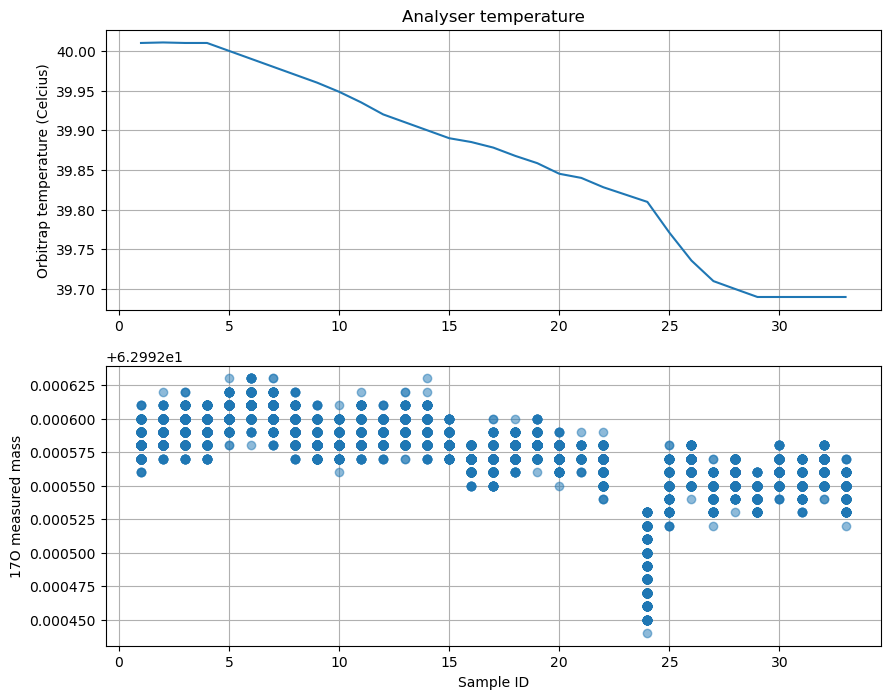

In [127]:
# Check 1:
# plot orbitrap temprature variations during run - variability may affect mass accuracy

fig,ax = plt.subplots(2, figsize=[10,8])
T = data_compiled.groupby('sample_ID')['analyzerTemperature'].mean()
ax[0].plot(T)
ax[0].set_ylabel('Orbitrap temperature (Celcius)')
ax[0].set_title('Analyser temperature')
ax[0].grid()

temp_range = T.max()-T.min()
print(f"Temperature range = {temp_range:.2f} celcius")

iso='17O'
data_i = data_compiled[data_compiled['isotopolog']==iso]
ax[1].plot(data_i['sample_ID'],data_i['mzMeasured'],lw=0,marker='o', alpha=0.5)
ax[1].grid()
ax[1].set_ylabel(iso+' measured mass')
ax[1].set_xlabel('Sample ID')
mz_range = data_i['mzMeasured'].max()-data_i['mzMeasured'].min()
print(f"{iso} peak has m/z range {mz_range*1e3:.2f} mmu")

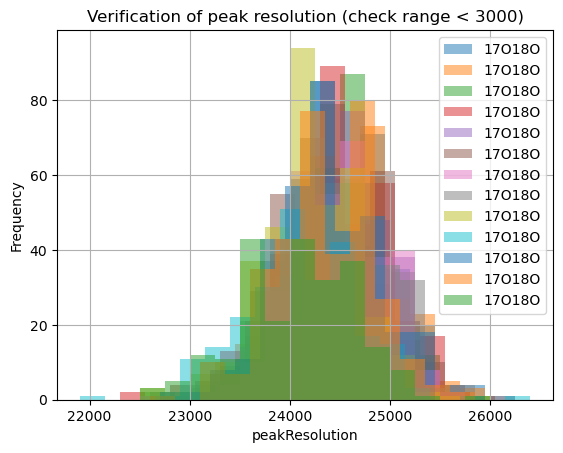

In [128]:
# Check 2:
# verify that the range of peakResolution values < 3000 for all isotopologues

def func(data_single_iso,n):
    # Extract the 'isotopolog' label
    isotopolog_label = index[0]
    # Plot the histogram
    bin_width=250
    min_val = data_single_iso['peakResolution'].min()
    max_val = data_single_iso['peakResolution'].max()
    if max_val-min_val>3000:
        print('Warning: peak resolution range > 3000 for',isotopolog_label,'.','Delta R =',max_val-min_val,'Injection',index[1])
        n+=1
        bins = np.arange(min_val, max_val + bin_width, bin_width)
        data_single_iso['peakResolution'].hist(bins=bins,alpha=0.5, label=isotopolog_label)  
    return n
        
    
# Group by 'isotopolog' and apply the function
n=0   # count instances of >3000
for index, group in data_compiled.groupby(['isotopolog', 'filename']):
    n = func(group, n)
if n==0:
    print('All isotopologue peak resolution ranges are < 3000')
else:
    # Show the plots
    plt.title('Verification of peak resolution (check range < 3000)')
    plt.xlabel('peakResolution')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


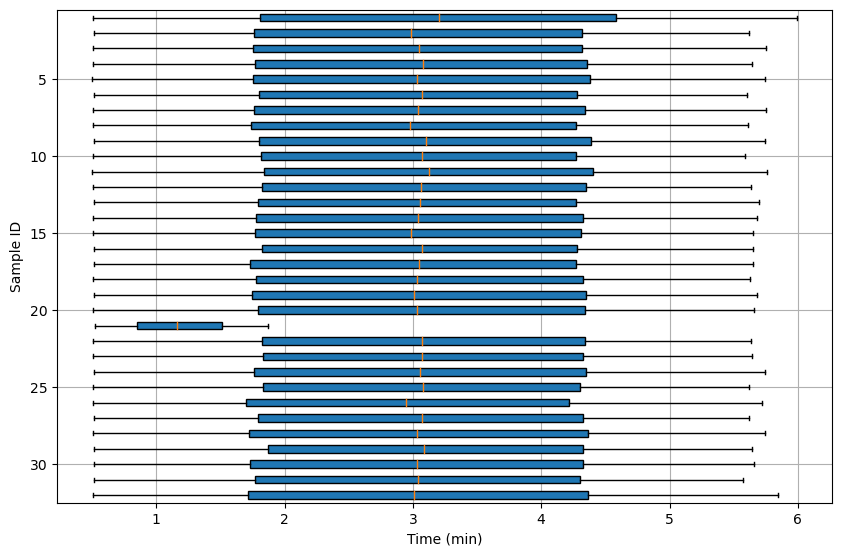

In [129]:
# Check 3:
# plot extracted time periods - check for anomolies

def extract_times(injection_data):
    t = injection_data[['time.min','sample_type']]
    return t

# Group by 'sample_ID' and apply the function
t = data_compiled.groupby('sample_ID').apply(extract_times, include_groups=False)

t_list = [t_group['time.min'].values for name, t_group in t.groupby('sample_ID')]
type_list = [type for type in t.groupby('sample_ID').first()['sample_type']]
ID_list = [int(ID) for ID in t.index.levels[0]]

# colours
colorlist=type_list.copy()
for i,type in enumerate(type_list):
    if type == 'Internal standard':
        colorlist[i]='#1f77b4'
    if type == 'Standard':
        colorlist[i]='#ff7f0e'
    if type == 'Sample':
        colorlist[i]='#2ca02c'
    if type == 'Unknown':
        colorlist[i]='#1f77b4'

fig,ax = plt.subplots(figsize=(10, 0.2*len(ID_list)))
boxplot = ax.boxplot(t_list, labels=ID_list, whis=[0,100],vert=False,patch_artist=True)

# Customizing each box with different colors
for patch, color in zip(boxplot['boxes'], colorlist):
    patch.set_facecolor(color)


ax.set_ylabel('Sample ID')
ax.set_xlabel('Time (min)')
ax.grid()
ax.invert_yaxis()
ax.set_yticks([val for val in ax.get_yticks() if val%5==0])
ax.set_yticklabels([val for val in ax.get_yticks() if val%5==0]);

## 2. Data verification and filtering
#### a. Extract block averages from scan data

In [205]:
# uses groupby() to calculate averages, copies all other data to a summary dataframe 'summ'

data = data_compiled.copy()
data['blockname']=data['filename'].copy()

# Extract blocknames
blocknames = data.groupby('sample_ID').first()['blockname']
isotopologues = [iso for iso in data[data['isotopolog']!=data['basepeak']]['isotopolog'].unique()]
# DataFrame for metadata
summ = pd.DataFrame(columns=['sample_ID','filename','sample_type','sample_name','position','blockname','compound','basepeak']+['ratio_'+iso for iso in isotopologues]+['sem_'+iso for iso in isotopologues]+['start_t_min','stop_t_min','scans','TIC_av','TIC_rse','TICxIT_av','TICxIT_std','integration_t_ms','scan_dur_ms','analyser_temp','notes'],index=blocknames)

for block,data_b in data.groupby('blockname'):
    summ.loc[block,['sample_ID','filename','sample_type','sample_name','position','blockname','compound','basepeak','notes']] = data_b[['sample_ID','filename','sample_type','sample_name','position','blockname','compound','basepeak','notes']].iloc[0]
    bp = data_b.loc[:,'basepeak'].iloc[0]
    
    for iso,data_bi in data_b.groupby('isotopolog'):
        if iso == bp:
            summ.loc[block,'start_t_min'] = data_bi['time.min'].min()
            summ.loc[block,'stop_t_min'] = data_bi['time.min'].max()
            summ.loc[block,'scans'] = len(data_bi)
            summ.loc[block,'TIC_av']= data_bi['tic'].mean()
            summ.loc[block,'TIC_rse']= data_bi['tic'].std()/data_bi['tic'].mean()
            summ.loc[block,'TICxIT_av']=np.mean(data_bi['tic']*data_bi['it.ms'])
            summ.loc[block,'TICxIT_std']=np.std(data_bi['tic']*data_bi['it.ms'])
            summ.loc[block,'integration_t_ms']= data_bi['it.ms'].mean()
            summ.loc[block,'scan_dur_ms'] = data_bi['time.min'].diff().median()
            summ.loc[block,'analyser_temp'] = data_bi['analyzerTemperature'].mean()
        if iso!=bp:
            summ.loc[block,'ratio_'+iso] = data_bi['ratio_to_basepeak'].mean()
            summ.loc[block,'sem_'+iso] = data_bi['ratio_to_basepeak'].sem()
            
print('Loaded '+ str(len(blocknames)) + ' sorted data blocks for samples:\n',summ[summ['sample_type']!='Internal standard']['sample_name'].unique())

summ

Loaded 32 sorted data blocks for samples:
 ['USGS35-IS' 'USGS35-100um-1' 'USGS34-100um-2']


,sample_ID,filename,sample_type,sample_name,position,blockname,compound,basepeak,ratio_15N18O,ratio_17O,...,stop_t_min,scans,TIC_av,TIC_rse,TICxIT_av,TICxIT_std,integration_t_ms,scan_dur_ms,analyser_temp,notes
blockname,,,,,,,,,,,,,,,,,,,,,
240905_001_20240905172145,1,240905_001_20240905172145,Unknown,USGS35-IS,G:A9,240905_001_20240905172145,NO3,15N,0.00825,0.326132,...,5.992,413,6174028.117433,0.009416,365912631.397759,1553516.928009,59.270712,0.013,40.01,
240905_002,2,240905_002,Unknown,USGS35-IS,G:A9,240905_002,NO3,15N,0.008234,0.326272,...,5.623,383,6179279.47389,0.042298,366061660.224089,1648489.422352,59.357272,0.013,40.010653,
240905_003,3,240905_003,Unknown,USGS35-IS,G:A9,240905_003,NO3,15N,0.008229,0.326058,...,5.755,382,5988621.668848,0.031283,366084548.245064,1576960.099067,61.19277,0.013,40.01,
240905_004,4,240905_004,Unknown,USGS35-IS,G:A9,240905_004,NO3,15N,0.008241,0.326665,...,5.642,366,5779149.814208,0.044839,366057948.281455,1706678.174805,63.48153,0.013,40.01,
240905_005,5,240905_005,Unknown,USGS35-100um-1,G:D1,240905_005,NO3,15N,0.008244,0.326358,...,5.743,342,5209966.747076,0.041787,366089930.353746,1359523.210161,70.404146,0.014,40.0,
240905_006,6,240905_006,Unknown,USGS35-IS,G:A9,240905_006,NO3,15N,0.008231,0.326404,...,5.606,357,5670048.764706,0.043008,365980104.259766,1488251.938866,64.678471,0.013,39.99,
240905_007,7,240905_007,Unknown,USGS35-100um-1,G:D1,240905_007,NO3,15N,0.008263,0.326347,...,5.75,339,5118628.019174,0.040752,365965435.37599,1472617.841868,71.629965,0.015,39.98,
240905_008,8,240905_008,Unknown,USGS35-IS,G:A9,240905_008,NO3,15N,0.00823,0.326314,...,5.608,350,5527834.857143,0.042925,366222124.274133,1625136.52727,66.386591,0.014,39.97,
240905_009,9,240905_009,Unknown,USGS35-100um-1,G:D1,240905_009,NO3,15N,0.008252,0.32609,...,5.745,330,5025441.093939,0.03853,366127475.694442,1552035.770615,72.975394,0.015,39.96,


### b. Check for outlying blocks

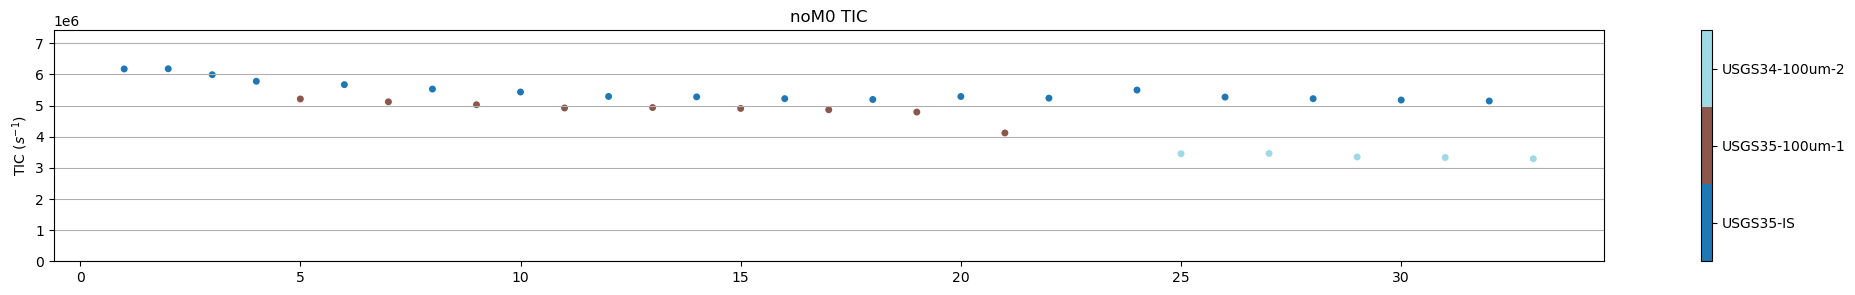

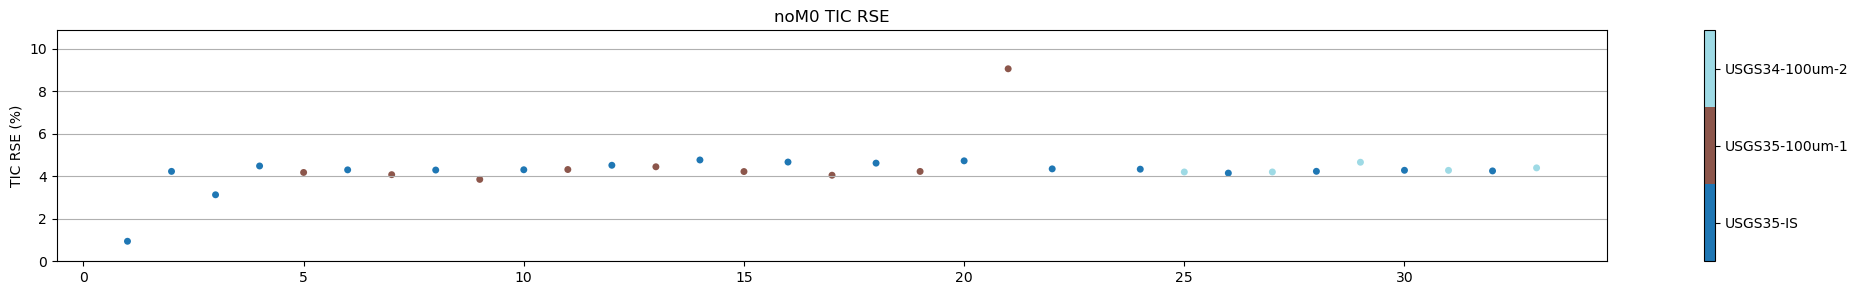

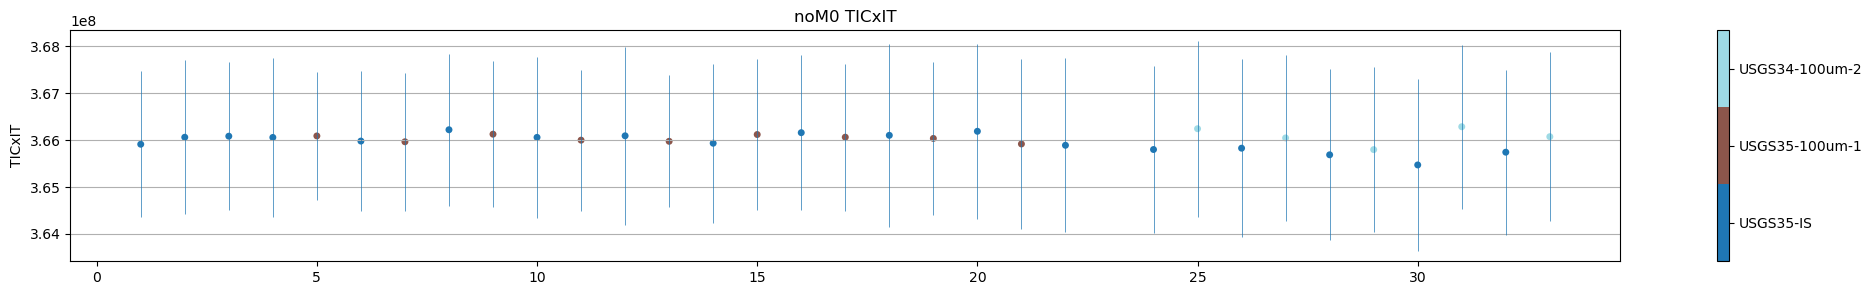

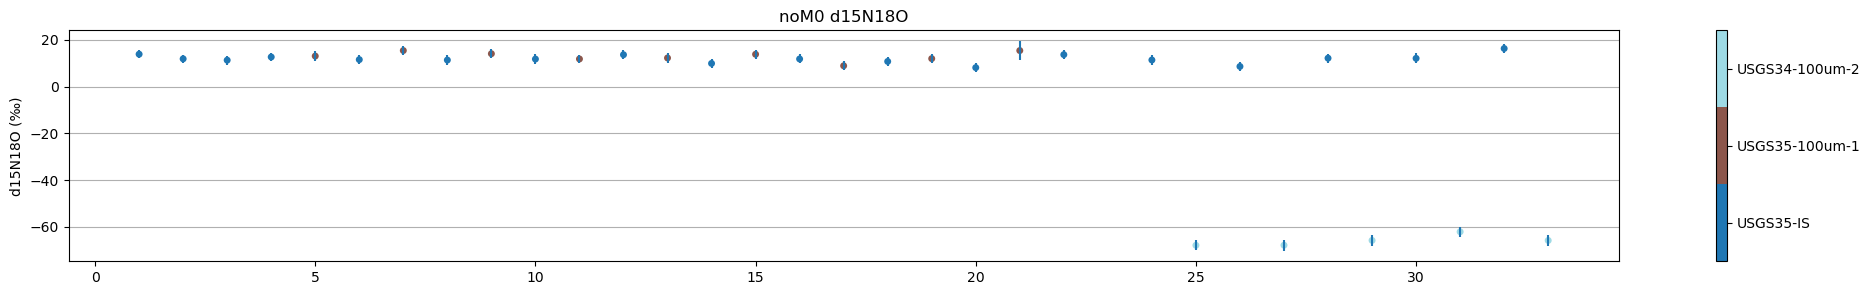

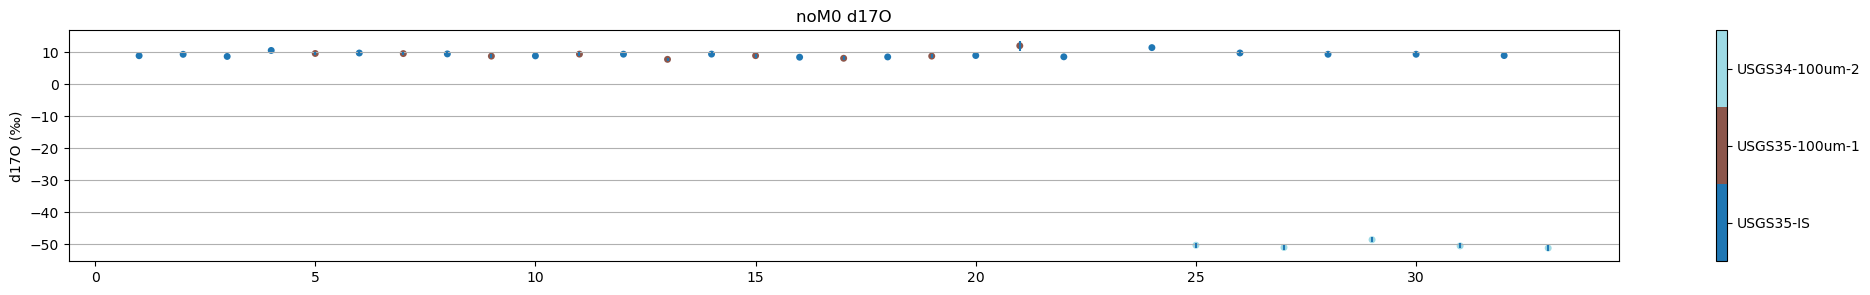

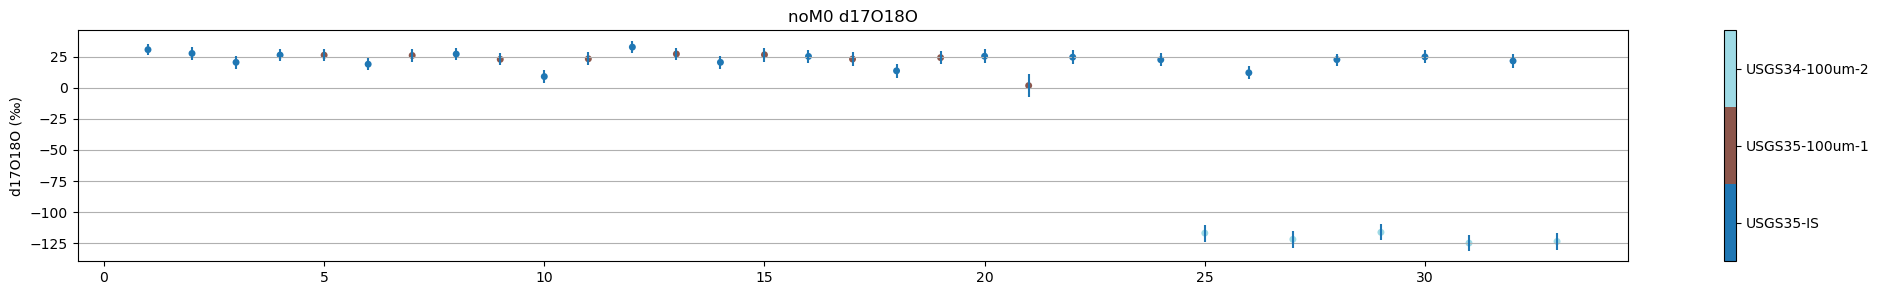

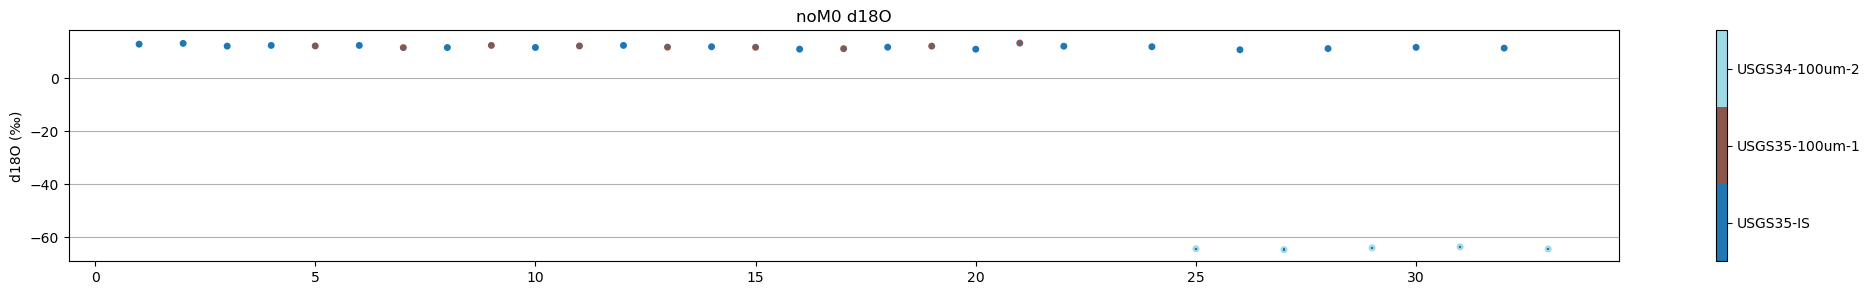

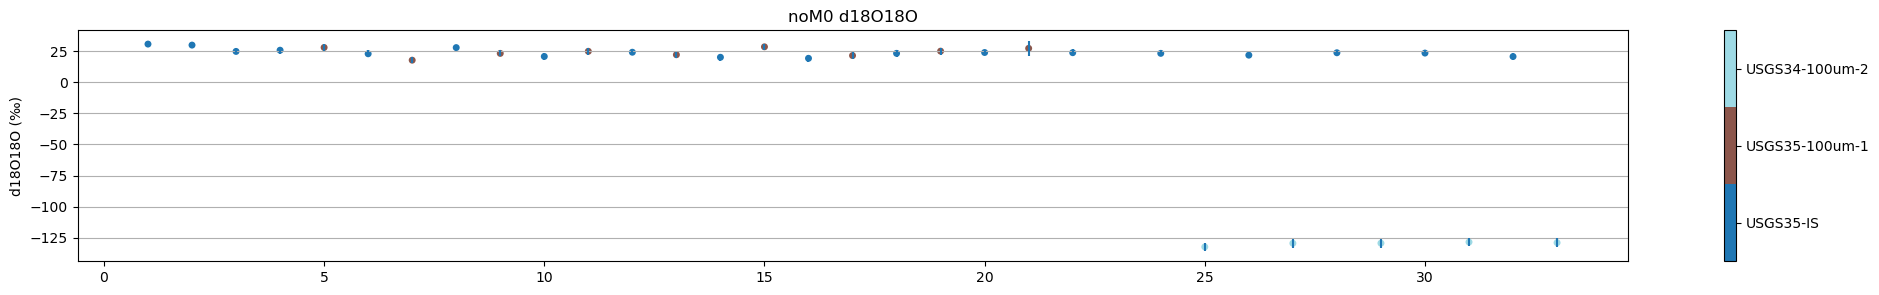

In [206]:
blocknames = summ.index
rcols = summ.columns[[col.startswith('ratio') for col in summ.columns]]

# identify M0 and/or noM0 experiments
exp_list = summ['basepeak'].unique()
for i,bp in enumerate(exp_list):
    if bp!='M0':
        exp_list[i]='noM0'

# separate M0 and noM0 data
for k,bp in enumerate(summ['basepeak'].unique()):
    summ1 = summ[summ['basepeak']==bp]
    if bp!='M0':
        exp='noM0'
    else:
        exp='M0'
    
    # colour mapping
    categories = summ1['sample_name']
    from matplotlib.colors import ListedColormap
    tab10_cmap = plt.get_cmap('tab20')
    colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
    discrete_cmap = ListedColormap(colors)
    category_mapping = {category: i for i, category in enumerate(categories.unique())}
    numeric_categories = np.array([category_mapping[category] for category in categories])
    discrete_cmap = plt.colormaps.get_cmap('tab20')

    # TIC plot
    fig,ax=plt.subplots(figsize=[25,3])
    scatter = ax.scatter(summ1['sample_ID'], summ1['TIC_av'], c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
    cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
    cbar.set_ticklabels(categories.unique())
    ax.grid(True, axis='y')
    ax.set_ylabel('TIC ($s^{-1}$)')
    ax.set_title(exp+' TIC')
    ax.set_ylim([0,1.2*max(summ1['TIC_av'])])
    
    # TIC RSE plot
    fig,ax=plt.subplots(figsize=[25,3])
    scatter = ax.scatter(summ1['sample_ID'], summ1['TIC_rse']*100, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
    cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
    cbar.set_ticklabels(categories.unique())
    ax.grid(True, axis='y')
    ax.set_ylabel('TIC RSE (%)')
    ax.set_title(exp+' TIC RSE')
    ax.set_ylim([0,120*max(summ1['TIC_rse'])])
    
    # TICxIT plot
    fig,ax=plt.subplots(figsize=[25,3])
    scatter = ax.scatter(x=summ1['sample_ID'],  # x-values
                      y=summ1['TICxIT_av'],  # y-values
                      c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
    ax.errorbar(x=summ1['sample_ID'], y=summ1['TICxIT_av'], yerr=summ1['TICxIT_std'], lw=0.5,ls='none',fmt='none')
    cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
    cbar.set_ticklabels(categories.unique())
    ax.grid(True, axis='y')
    ax.set_ylabel('TICxIT')
    ax.set_title(exp+' TICxIT')

    # isotopologue ratio plots
    for i,col in enumerate(rcols):
        # check for empty column
        if len(summ1[col].dropna())>1:
            fig,ax=plt.subplots(figsize=[25,3])
            scatter = ax.scatter(summ1['sample_ID'], (summ1[col]/summ1[col].mean()-1)*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.', s=100)
            ax.errorbar(summ1['sample_ID'], (summ1[col]/summ1[col].mean()-1)*1000, yerr=(summ1['sem_'+col[6:]]/summ1[col])*1000, fmt='none')
            cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
            cbar.set_ticklabels(categories.unique())
            ax.grid(True, axis='y')
            ax.set_ylabel('d' + col.split('_')[-1] + ' (‰)')
            ax.set_title(exp+' d' + col.split('_')[-1])



### c. Plot TIC and rolling $\delta^{18}O$ for each block, check for outliers
Input: meandur (rolling mean duration in minutes)

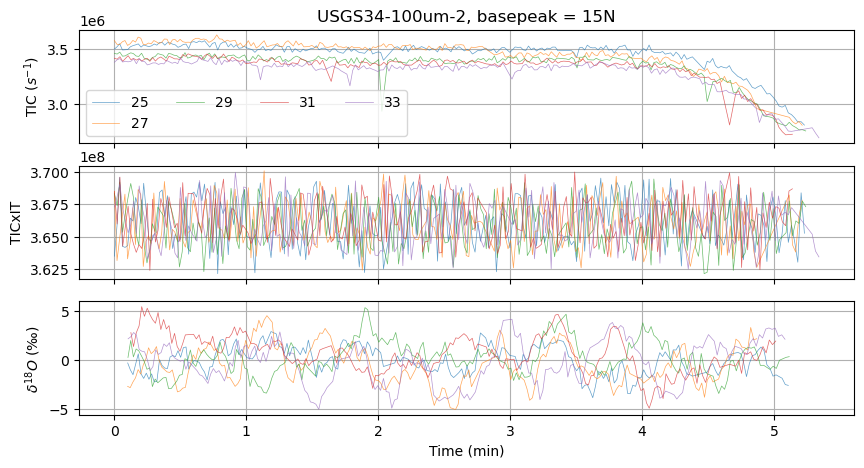

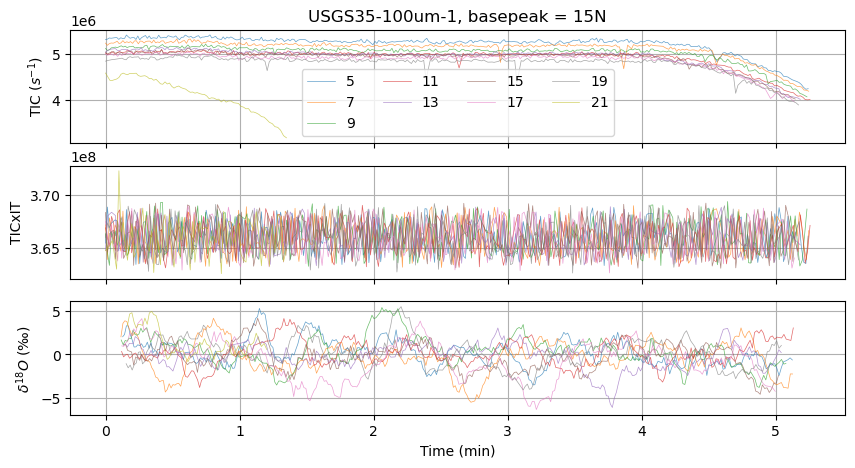

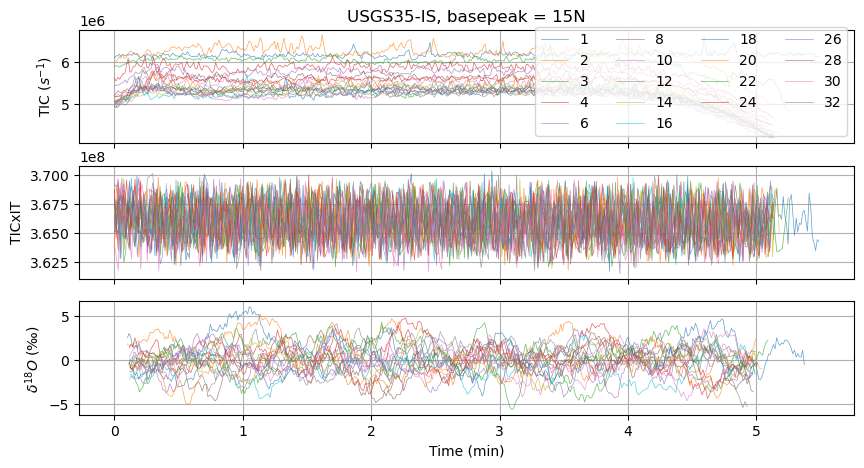

In [207]:
for (sample,basepeak), data_sb in data_compiled[data_compiled['isotopolog']=='18O'].groupby(['sample_name','basepeak']):
    
    fig,ax = plt.subplots(3, figsize = [10,5])
    ax[0].set_title(sample +', basepeak = '+basepeak)
    
    ref_18O = data_sb['ratio_to_basepeak'].mean()
                
    for sample_ID, data_sbi in data_sb.groupby('sample_ID'):
        
        scandur = data_sb['time.min'].diff().median()
        meandur = 0.5  # minutes for rolling mean calculation
        window_size = int(meandur / scandur)
        if basepeak=='M0':
            data_sbi['Rolling_18O'] = data_sbi['ratio_to_basepeak'].rolling(window=window_size, center=True).mean()
        else:
            data_sbi['Rolling_18O'] = data_sbi['ratio_to_basepeak'].rolling(window=int(window_size/2), center=True).mean()
                
        ax[0].plot(data_sbi['time.min']-data_sbi['time.min'].min(),data_sbi['tic'], label=sample_ID, lw=0.5,alpha=0.7)
        ax[0].grid(True,axis='both')
        ax[0].set_ylabel('TIC ($s^{-1}$)')
        ax[0].legend(ncols=4)        
        ax[0].set_xticklabels([])

        ax[1].plot(data_sbi['time.min']-data_sbi['time.min'].min(),data_sbi['tic']*data_sbi['it.ms'], label=sample_ID, lw=0.5,alpha=0.7)
        ax[1].grid(True,axis='both')
        ax[1].set_ylabel('TICxIT')   
        ax[1].set_xticklabels([])

        ax[2].plot(data_sbi['time.min']-data_sbi['time.min'].min(),1000*(data_sbi['Rolling_18O']/ref_18O-1), lw=0.5,alpha=0.7)
        ax[2].set_xlim(ax[0].get_xlim())
        ax[2].grid(True,axis='both')
        ax[2].set_ylabel('$\delta^{18}O$ (‰)')


        ax[-1].set_xlabel('Time (min)')

### d. Block filtering
Remove unfaithful injections using filters or by hand   
Saves a filtered summary file '_summary_filtered.csv'

In [208]:
print('List of the first occurence of each sample name')

summ.groupby('sample_name').first().sort_values('sample_ID')
# summ[['sample_name','experiment']]

List of the first occurence of each sample name


,sample_ID,filename,sample_type,position,blockname,compound,basepeak,ratio_15N18O,ratio_17O,ratio_17O18O,...,stop_t_min,scans,TIC_av,TIC_rse,TICxIT_av,TICxIT_std,integration_t_ms,scan_dur_ms,analyser_temp,notes
sample_name,,,,,,,,,,,,,,,,,,,,,
USGS35-IS,1,240905_001_20240905172145,Unknown,G:A9,240905_001_20240905172145,NO3,15N,0.00825,0.326132,0.00174,...,5.992,413,6174028.117433,0.009416,365912631.397759,1553516.928009,59.270712,0.013,40.01,
USGS35-100um-1,5,240905_005,Unknown,G:D1,240905_005,NO3,15N,0.008244,0.326358,0.001733,...,5.743,342,5209966.747076,0.041787,366089930.353746,1359523.210161,70.404146,0.014,40.0,
USGS34-100um-2,25,240905_025,Unknown,G:B2,240905_025,NO3,15N,0.007585,0.306964,0.001491,...,5.747,240,3453239.335417,0.042013,366244283.483776,1877469.290723,106.264929,0.02,39.771,


In [209]:
# filter blocks using to_remove.csv
to_remove_filtering=False
# filter blocks manually using code below
manual_filtering=True

summ['to_remove'] = False

# load samples to remove from file
if os.path.exists(os.path.join(pathresults,'to_remove.csv'))&to_remove_filtering==True:
    to_remove = pd.read_csv(os.path.join(pathresults,'to_remove.csv'),index_col='blockname')

    for i,block in enumerate(summ['blockname']):
        if block not in to_remove.index:
            print(block, 'not found in to_remove')
        elif to_remove.loc[block,'to_remove']==True:
            summ['to_remove'] = summ['to_remove']|(summ['blockname']==block)
            print(block, 'removed using to_remove')
    
# specify files to remove manually
if manual_filtering==True:
    # blank filter
    if True:
        summ['to_remove'] = summ['sample_name'].str.startswith('MQ')
        print('Removed '+str(len(summ[summ['to_remove']])) + ' blank blocks: \n'+ str(list(summ[summ['to_remove']]['blockname'])))

    # minimum TIC filter
    if False:
        minTIC=1e7
        summ['to_remove'] = summ['to_remove']|(summ['TIC_av']<minTIC)
        print('\nRemoved '+str(len(summ[summ['TIC_av']<minTIC])) + ' further blocks with low TIC \n'+ str(list(summ[summ['TIC_av']<minTIC]['blockname'])))

    # TICxIT filter
    if True:
        minTICIT=summ['TICxIT_av'].median()*0.95
        maxTICIT=summ['TICxIT_av'].median()*1.05
        summ['to_remove'] = summ['to_remove']|((summ['TICxIT_av']<minTICIT) | (summ['TICxIT_av']>maxTICIT))
        print('\nRemoved '+str(len(summ[(summ['TICxIT_av']<minTICIT) | (summ['TICxIT_av']>maxTICIT)])) + ' further blocks with outlying TICxIT \n'+ str(list(summ[(summ['TICxIT_av']<minTICIT) | (summ['TICxIT_av']>maxTICIT)]['blockname'])))

    # Other injection numbers to remove by sample ID or name
    remove = [21]
    remove_blockname = []
    remove_samplename = ['USGS34_2','NICO6_2']
    summ['to_remove'] = summ['to_remove']|(summ['sample_ID'].isin(remove))|(summ['blockname'].isin(remove_blockname))|(summ['sample_name'].isin(remove_samplename))
    print('\nRemoved '+str(len(summ[(summ.index.isin(remove))|(summ['blockname'].isin(remove_blockname))])) + ' addional blocks: \n'+ str(list(summ[(summ.index.isin(remove))|(summ['blockname'].isin(remove_blockname))]['blockname'])))

# remove labelled blocks
summ_filt = summ[summ['to_remove']==False].reset_index(drop=True)

# sort to seperate m0 and no-m0 data for bracketing
summ_filt = pd.concat([summ_filt[summ_filt['basepeak']=='M0'],summ_filt[summ_filt['basepeak']!='M0']]).reset_index(drop=True)
print('\nSeperated M0 and noM0 data:\n',
      summ_filt[['sample_name','blockname','basepeak']].head(10),
      '\n',summ_filt[['sample_name','blockname','basepeak']].tail(10))

# export summary files as csv  
summ[['blockname','to_remove']].to_csv(os.path.join(pathresults,'to_remove.csv'))
summ_filt.to_csv(os.path.join(pathresults,'summary_filtered.csv'))
summ.to_csv(os.path.join(pathresults,'summary_nonfiltered.csv'))
print('\nSaved unfiltered summary file as ' + os.path.join(pathresults,'summary_nonfiltered.csv.'))
print('Saved filtering list as ' + os.path.join(pathresults,'to_remove.csv.'))
print('Saved filtered summary file as ' + os.path.join(pathresults,'summary_filtered.csv.'))
print('\nRemoved blocks:')
summ[summ['to_remove']==True]

Removed 0 blank blocks: 
[]

Removed 0 further blocks with outlying TICxIT 
[]

Removed 0 addional blocks: 
[]

Seperated M0 and noM0 data:
       sample_name                  blockname basepeak
0       USGS35-IS  240905_001_20240905172145      15N
1       USGS35-IS                 240905_002      15N
2       USGS35-IS                 240905_003      15N
3       USGS35-IS                 240905_004      15N
4  USGS35-100um-1                 240905_005      15N
5       USGS35-IS                 240905_006      15N
6  USGS35-100um-1                 240905_007      15N
7       USGS35-IS                 240905_008      15N
8  USGS35-100um-1                 240905_009      15N
9       USGS35-IS                 240905_010      15N 
        sample_name   blockname basepeak
21       USGS35-IS  240905_024      15N
22  USGS34-100um-2  240905_025      15N
23       USGS35-IS  240905_026      15N
24  USGS34-100um-2  240905_027      15N
25       USGS35-IS  240905_028      15N
26  USGS34-100um-2  240

,sample_ID,filename,sample_type,sample_name,position,blockname,compound,basepeak,ratio_15N18O,ratio_17O,...,scans,TIC_av,TIC_rse,TICxIT_av,TICxIT_std,integration_t_ms,scan_dur_ms,analyser_temp,notes,to_remove
blockname,,,,,,,,,,,,,,,,,,,,,
240905_021,21,240905_021,Unknown,USGS35-100um-1,G:D1,240905_021,NO3,15N,0.008263,0.327139,...,74,4119037.016892,0.090568,365918911.055777,1810292.323221,89.616473,0.018,39.84,,True


Text(0.5, 1.0, 'noM0 TICxIT')

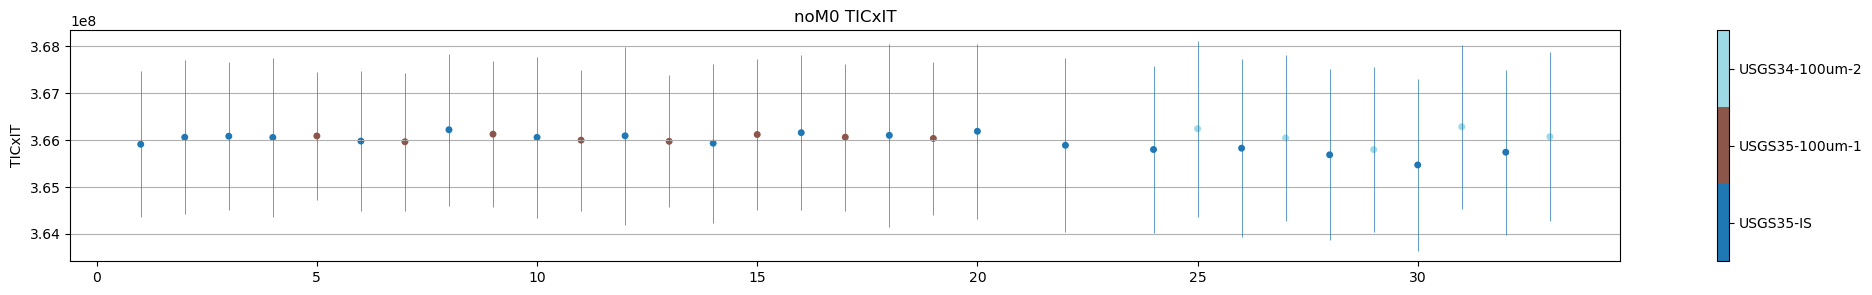

In [210]:
# plot after filtering
# colour mapping
categories = summ_filt['sample_name']
from matplotlib.colors import ListedColormap
tab10_cmap = plt.get_cmap('tab20')
colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
discrete_cmap = ListedColormap(colors)
category_mapping = {category: i for i, category in enumerate(categories.unique())}
numeric_categories = np.array([category_mapping[category] for category in categories])
discrete_cmap = plt.colormaps.get_cmap('tab20')

# TICxIT plot
fig,ax=plt.subplots(figsize=[25,3])
scatter = ax.scatter(x=summ_filt['sample_ID'],  # x-values
                  y=summ_filt['TICxIT_av'],  # y-values
                  c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
ax.errorbar(x=summ_filt['sample_ID'], y=summ_filt['TICxIT_av'], yerr=summ_filt['TICxIT_std'], lw=0.5,ls='none',fmt='none')
cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
cbar.set_ticklabels(categories.unique())
ax.grid(True, axis='y')
ax.set_ylabel('TICxIT')
ax.set_title(exp+' TICxIT')

## 3. Calculation of delta values
### a. Bracketing
Uses brackting formula: $\delta = \frac{2R_i}{R_{i-1}+R_{i+1}}-1$ to calculate internal deltas for each isotopologue for every sample which is surrounded by internal standards.  
- Saves internal deltas as 'internal_deltas_YYYY-MM-DD.csv'.  
- Saves summary as 'internal_deltas_summary_YYYY-MM-DD.csv' with mean and sem for each isotopologue for each sample.


Internal standard manually selected: USGS35-IS
Bracketed internal delta values relative to basepeak saved as results_2024-09-16/internal_deltas_2024-09-16.csv
Summarised ouptut saved as results_2024-09-16/internal_deltas_summary_2024-09-16.csv


,sample_type,position,basepeak,rel_to,scans_sample,scans_std,mean_d15N18O,mean_d17O,mean_d17O18O,mean_d18O,mean_d18O18O,err_d15N18O,err_d17O,err_d17O18O,err_d18O,err_d18O18O,TIC_sample,TIC_std,notes,order
sample_name,,,,,,,,,,,,,,,,,,,,
USGS35-100um-1,Unknown,G:D1,15N,USGS35-IS 15N peak,2615,2.76e+03,1.25,-0.33,3.24,0.10,0.97,0.85,0.24,2.27,0.17,1.61,4.97e+06,5.39e+06,,0
USGS34-100um-2,Unknown,G:B2,15N,USGS35-IS 15N peak,935,1.35e+03,-76.75,-59.28,-137.41,-74.57,-149.34,1.34,0.64,3.62,0.25,1.84,3.4e+06,5.25e+06,,1


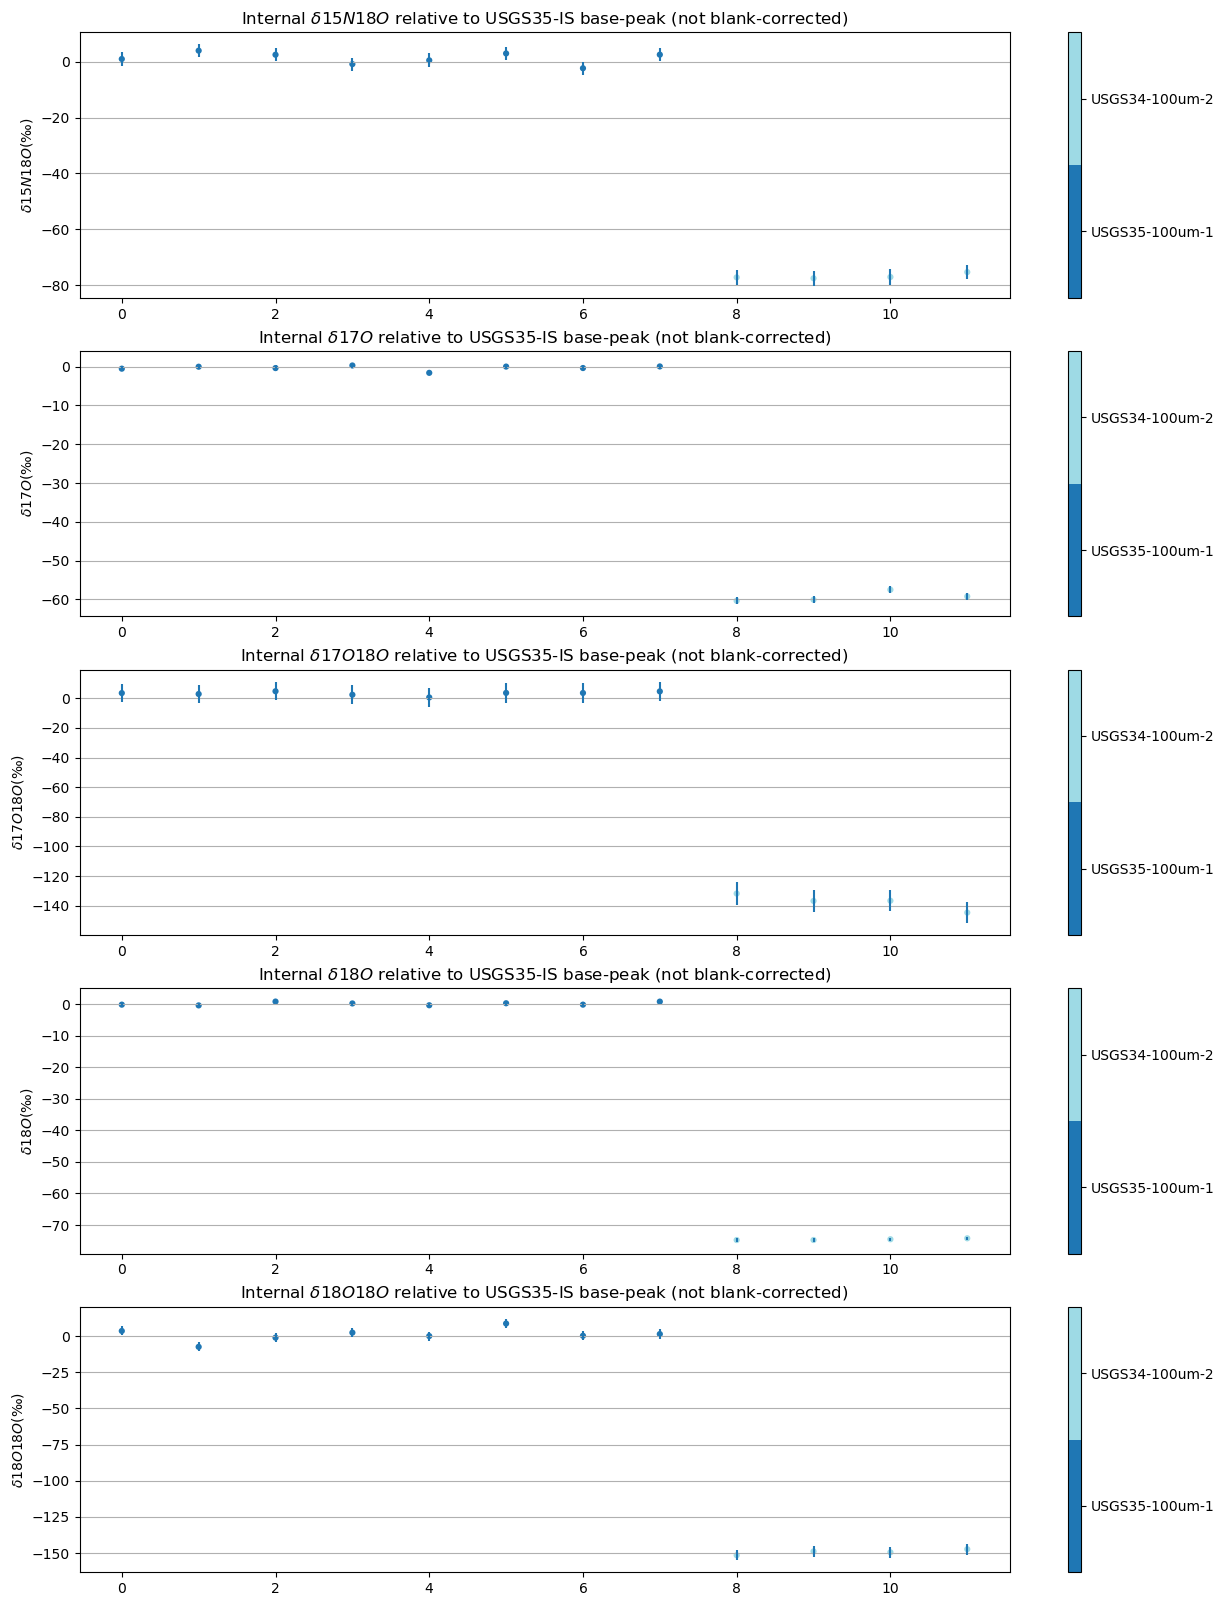

In [211]:
# identify internal standard
if len(summ_filt[summ_filt['sample_type']=='Internal standard']['sample_name'].unique())==1:
    int_std = summ_filt[summ_filt['sample_type']=='Internal standard']['sample_name'].iloc[0]
    print('Identified internal standard',int_std)
else:
    int_std = 'USGS35-IS'
    print("Internal standard manually selected:",int_std)
    

# identify isotopologs
isotopologues = [col.split('_')[1] for col in summ_filt.columns if col.split('_')[0]=='ratio']
    
# identify sample injections
samples = summ_filt[summ_filt['sample_name'] != int_std]
samples_delta = pd.DataFrame(columns=['sample_type','sample_name','position','blockname','basepeak']+['d'+iso for iso in isotopologues]+['err_d'+iso for iso in isotopologues]+['rel_to','TIC_sample','scans_sample','scans_std','notes'],index = samples.index)
samples_delta.loc[:,['sample_ID','sample_type','sample_name','position','blockname','basepeak','notes']]=samples.loc[:,['sample_ID','sample_type','sample_name','position','blockname','basepeak','notes']]


# bracketing
for i in samples.index:
    if i-1 in summ_filt.index and i+1 in summ_filt.index:
        if summ_filt.loc[i-1,'sample_name']== int_std and summ_filt.loc[i+1,'sample_name']==int_std:
            # calc delta
            R_i = summ_filt.loc[i,['ratio_'+iso for iso in isotopologues]]
            R_minus = summ_filt.loc[i-1,['ratio_'+iso for iso in isotopologues]]
            R_plus = summ_filt.loc[i+1,['ratio_'+iso for iso in isotopologues]]
            deltas = 2*R_i/(R_minus+R_plus)-1
            samples_delta.loc[i,['d'+iso for iso in isotopologues]] = deltas.tolist()
            # calc error
            e_i = summ_filt.loc[i,['sem_'+iso for iso in isotopologues]]
            e_minus = summ_filt.loc[i-1,['sem_'+iso for iso in isotopologues]]
            e_plus = summ_filt.loc[i+1,['sem_'+iso for iso in isotopologues]]
            err_d = e_i.copy()
            for sem_iso in e_i.index:
                err_d.loc[sem_iso] = ((2*e_i[sem_iso])**2 + e_minus[sem_iso]**2 + e_plus[sem_iso]**2)**0.5/(0.5*R_minus['ratio_'+sem_iso[4:]]+0.5*R_plus['ratio_'+sem_iso[4:]]+R_i['ratio_'+sem_iso[4:]])
            samples_delta.loc[i,['err_d'+iso for iso in isotopologues]] = err_d.tolist()
            
        samples_delta.loc[i,'rel_to'] = int_std+' '+samples_delta.loc[i,'basepeak']+' peak'
        samples_delta.loc[i,'TIC_sample']=summ_filt.loc[i,'TIC_av']
        samples_delta.loc[i,'TIC_std']=0.5*(summ_filt.loc[i-1,'TIC_av']+summ_filt.loc[i+1,'TIC_av'])
        samples_delta.loc[i,'scans_sample']=summ_filt.loc[i,'scans']
        samples_delta.loc[i,'scans_std']=0.5*(summ_filt.loc[i-1,'scans']+summ_filt.loc[i+1,'scans'])
        samples_delta.loc[i,'notes']=summ_filt.loc[i,'notes']
samples_delta.dropna(how='all',subset=['d'+iso for iso in isotopologues],inplace=True)
samples_delta.reset_index(inplace=True,drop=True)

# save
samples_delta.to_csv(os.path.join(pathresults,'internal_deltas_'+current_date_string+'.csv'))
print('Bracketed internal delta values relative to basepeak saved as '+ os.path.join(pathresults,'internal_deltas_'+current_date_string+'.csv'))

# summarise internal deltas per sample/experiment combo
stats=pd.DataFrame()
stats['sample_ID']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['sample_ID']
stats['sample_name']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['sample_name']
stats['sample_type']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['sample_type']
stats['position']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['position']
stats['basepeak']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['basepeak']
stats['rel_to']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['rel_to']
stats['scans_sample']=samples_delta.groupby(['sample_name','basepeak']).sum().reset_index()['scans_sample']
stats['scans_std']=samples_delta.groupby(['sample_name','basepeak']).sum().reset_index()['scans_std']
# mean delta
stats[['mean_d'+iso for iso in isotopologues]]=samples_delta.groupby(['sample_name','basepeak'])[['d'+iso for iso in isotopologues]].mean().reset_index()[['d'+iso for iso in isotopologues]]
# sem of N injections
sem=samples_delta.groupby(['sample_name','basepeak'])[['d'+iso for iso in isotopologues]].sem().reset_index()[['d'+iso for iso in isotopologues]]
# propogated error = sqrt(sum(err^2)/N))
def add_in_quadrature(errors):
    N = len(errors)
    return (np.sum(errors**2,axis=0)**0.5/N)
errprop = samples_delta.groupby(['sample_name','basepeak'])[['err_d'+iso for iso in isotopologues]].apply(add_in_quadrature).reset_index()[['err_d'+iso for iso in isotopologues]]
# select the grater error val
sem.columns = errprop.columns
stats[['err_d'+iso for iso in isotopologues]] = np.fmax(errprop,sem)

stats['TIC_sample'] = samples_delta.groupby(['sample_name','basepeak'])['TIC_sample'].mean().reset_index()['TIC_sample']
stats['TIC_std'] = samples_delta.groupby(['sample_name','basepeak'])['TIC_std'].mean().reset_index()['TIC_std']
stats['notes'] = samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['notes']
# sort, put sample name as index
stats = stats.sort_values('sample_ID').reset_index(drop=True)
stats['order']=stats.index
stats.index=stats['sample_name']
stats.drop(['sample_name','sample_ID'],axis=1,inplace=True)

# plot
if True:
    fig,ax = plt.subplots(len(isotopologues), figsize=[15,4*len(isotopologues)])

    categories = samples_delta['sample_name']
    from matplotlib.colors import ListedColormap
    tab10_cmap = plt.get_cmap('tab20')
    colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
    discrete_cmap = ListedColormap(colors)
    category_mapping = {category: i for i, category in enumerate(categories.unique())}
    numeric_categories = np.array([category_mapping[category] for category in categories])

    for i,iso in enumerate(isotopologues):
        scatter = ax[i].scatter(samples_delta.index, samples_delta['d'+iso]*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=80)
        ax[i].errorbar(samples_delta.index, samples_delta['d'+iso]*1000, yerr=samples_delta['err_d'+iso]*1000, fmt='none')
        cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories)) + 1) - 0.5)
        cbar.set_ticklabels(categories.unique())
        ax[i].grid(True, axis='y')
        ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
        ax[i].set_title('Internal $\delta' + iso +'$ relative to '+int_std+' base-peak (not blank-corrected)')
        # ax[i].set_xticks([])

        
# save
stats.to_csv(os.path.join(pathresults,'internal_deltas_summary_'+current_date_string+'.csv'))
print('Summarised ouptut saved as '+os.path.join(pathresults,'internal_deltas_summary_'+current_date_string+'.csv'))


# function to multiply only deltas by 1e3
def multiply_numerical(x):
    if isinstance(x,float):
        if abs(x)<1:
            return '{:.2f}'.format(x * 1e3)
        else:
            return '{:.3g}'.format(x)
    else:
        return x
# display
stats.map(multiply_numerical).head(20)

### b. Conversion of internal deltas to international scale based on values of internal standard
Reference delta values of internal standard are taken from the reference data (inputs at top of script).  

Saves external deltas:
- Saves external deltas as 'external_deltas_YYYY-MM-DD.csv'.
- Saves summary as 'external_deltas_summary_YYYY-MM-DD.csv' with mean and sem for each isotopologue for each sample.


Imported reference data for internal standard USGS35 from references_nitrate.xlsx
mean_d15N           0.002700
mean_d17O           0.051500
mean_d18O           0.057500
mean_d18O/15N       0.054652
mean_d17O/15N       0.048669
mean_d15N18O/15N    0.057500
mean_d17O18O/15N    0.108967
mean_d18O18O/15N    0.115295
Name: USGS35, dtype: float64
Changed reference of internal deltas to international reference scale. 
Summarised output saved as results_2024-09-16/external_deltas_2024-09-16.csv


,sample_type,position,basepeak,rel_to,scans_sample,scans_std,mean_d15N18O,mean_d17O,mean_d17O18O,mean_d18O,mean_d18O18O,err_d15N18O,err_d17O,err_d17O18O,err_d18O,err_d18O18O,TIC_sample,TIC_std,notes,order
sample_name,,,,,,,,,,,,,,,,,,,,
USGS35-100um-1,Unknown,G:D1,15N,international reference 15N peak,2615,2.76e+03,58.82,48.32,112.56,54.76,116.37,0.85,0.24,2.27,0.17,1.61,4.97e+06,5.39e+06,,0
USGS34-100um-2,Unknown,G:B2,15N,international reference 15N peak,935,1.35e+03,-23.66,-13.50,-43.42,-23.99,-51.27,1.34,0.64,3.62,0.25,1.84,3.4e+06,5.25e+06,,1


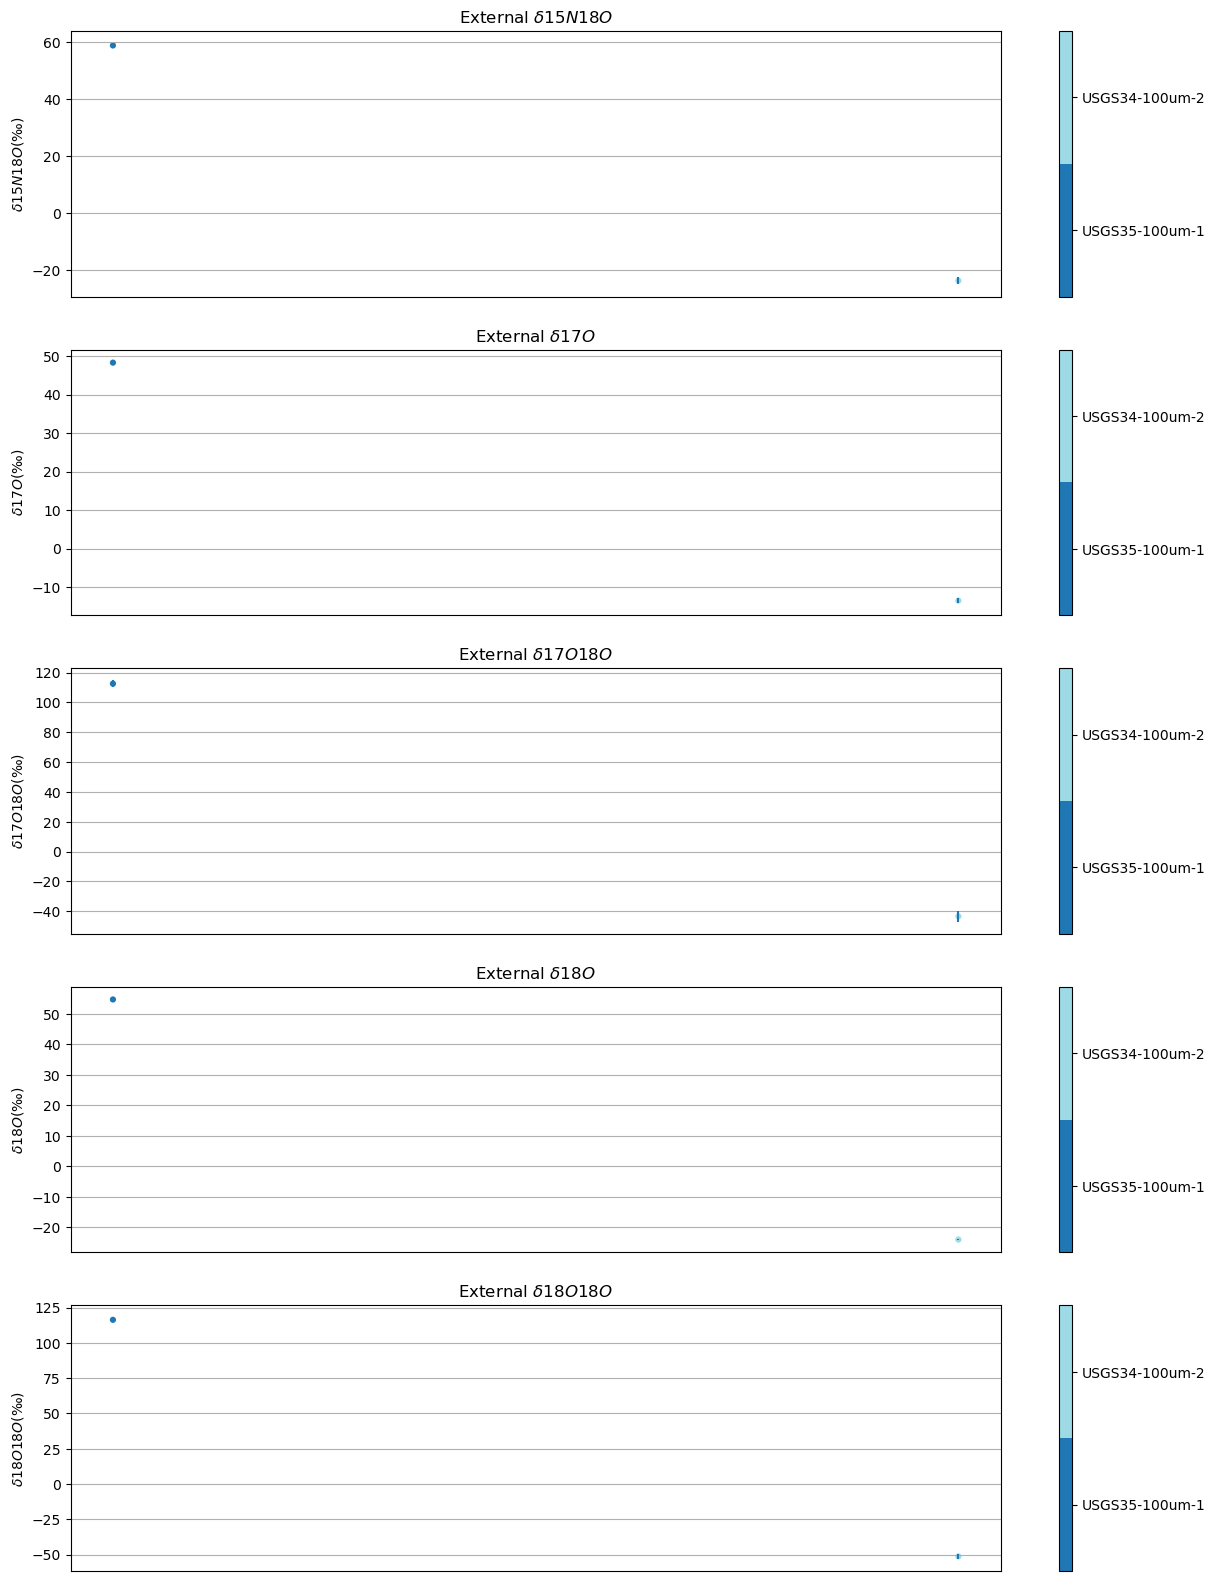

In [214]:
df = stats.copy()

# Import reference data for internal standard

references = pd.read_excel(ref_filename, index_col='sample_name')

internal_std_short = int_std.split('-')[0]
refs_stats = references.loc[internal_std_short]
refs_stats = refs_stats*1e-3

# display
print('Imported reference data for internal standard '+internal_std_short+' from '+ ref_filename)
print(refs_stats[[iso for iso in refs_stats.index if iso.startswith('mean_d')]])

# change reference to international scale based on internal standard supposed values
df_international_scale=df.copy()
for sample in df.index:
    # identify isotopologues
    isotopolog_cols = [iso for iso in df.columns if iso.startswith('mean')]
    # identify basepeak
    bp = df.loc[sample,'basepeak']
    # identify and rename the internal standard used
    int_std_name = df.loc[sample,'rel_to']
    int_std_name = int_std_name.split('-')[0]
    # select internal standard delta vals
    if int_std_name == refs_stats.name:
        if bp=='M0':
            int_std_cols = [iso for iso in isotopolog_cols  if iso in refs_stats.index ]
        elif bp in ['15N','18O']:
            int_std_cols = [iso+'/'+bp for iso in isotopolog_cols  if iso+'/'+bp in refs_stats.index ]
        else:
            print('Basepeak not identified for',sample)
        int_std_deltas = refs_stats.loc[int_std_cols]
         # correct using change of reference formula
        for col in int_std_deltas.index:
            d1 = df.loc[sample, col.split('/')[0]] # internal delta for all samples
            d2 = int_std_deltas[col]  #delta of standard
            d_corr = d1 + d2 + d1*d2
            df_international_scale.loc[sample, col.split('/')[0]] = d_corr
        df_international_scale.loc[sample,'rel_to'] = 'international reference'+' '+df.loc[sample,'basepeak']+' peak'
    else:
        print("Couldn't find standard: "+ int_std_name+ ' in reference data. Using internal deltas for '+ str(df.loc[i,'sample_name']))

# save deltas as csv
df_international_scale.to_csv(os.path.join(pathresults,'external_deltas_'+current_date_string+'.csv'))
print('Changed reference of internal deltas to international reference scale. \nSummarised output saved as '+os.path.join(pathresults,'external_deltas_'+current_date_string+'.csv'))

# plot
fig,ax = plt.subplots(len(isotopologues), figsize=[15,4*len(isotopologues)])

categories = df_international_scale.index
from matplotlib.colors import ListedColormap
tab10_cmap = plt.get_cmap('tab20')
colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
discrete_cmap = ListedColormap(colors)
category_mapping = {category: i for i, category in enumerate(categories.unique())}
numeric_categories = np.array([category_mapping[category] for category in categories])

for i,iso in enumerate(isotopologues):
    scatter = ax[i].scatter(df_international_scale.index, df_international_scale['mean_d'+iso]*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=80)
    ax[i].errorbar(df_international_scale.index, df_international_scale['mean_d'+iso]*1000, yerr=df_international_scale['err_d'+iso]*1000, fmt='none')
    cbar = plt.colorbar(scatter, ticks=pd.Series(numeric_categories).unique(), boundaries=np.arange(len(pd.Series(numeric_categories).unique() )+ 1) - 0.5)
    cbar.set_ticklabels(pd.Series(categories).unique())
    ax[i].grid(True, axis='y')
    ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
    ax[i].set_title('External $\delta' + iso +'$')
    ax[i].set_xticks([])
    

# display
df_international_scale.map(multiply_numerical).head(20)

## Plot final results

/var/folders/rr/bz6rnlcn09b6b2ttxx8h8x5m0000gn/T/ipykernel_43917/4293042951.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=90)


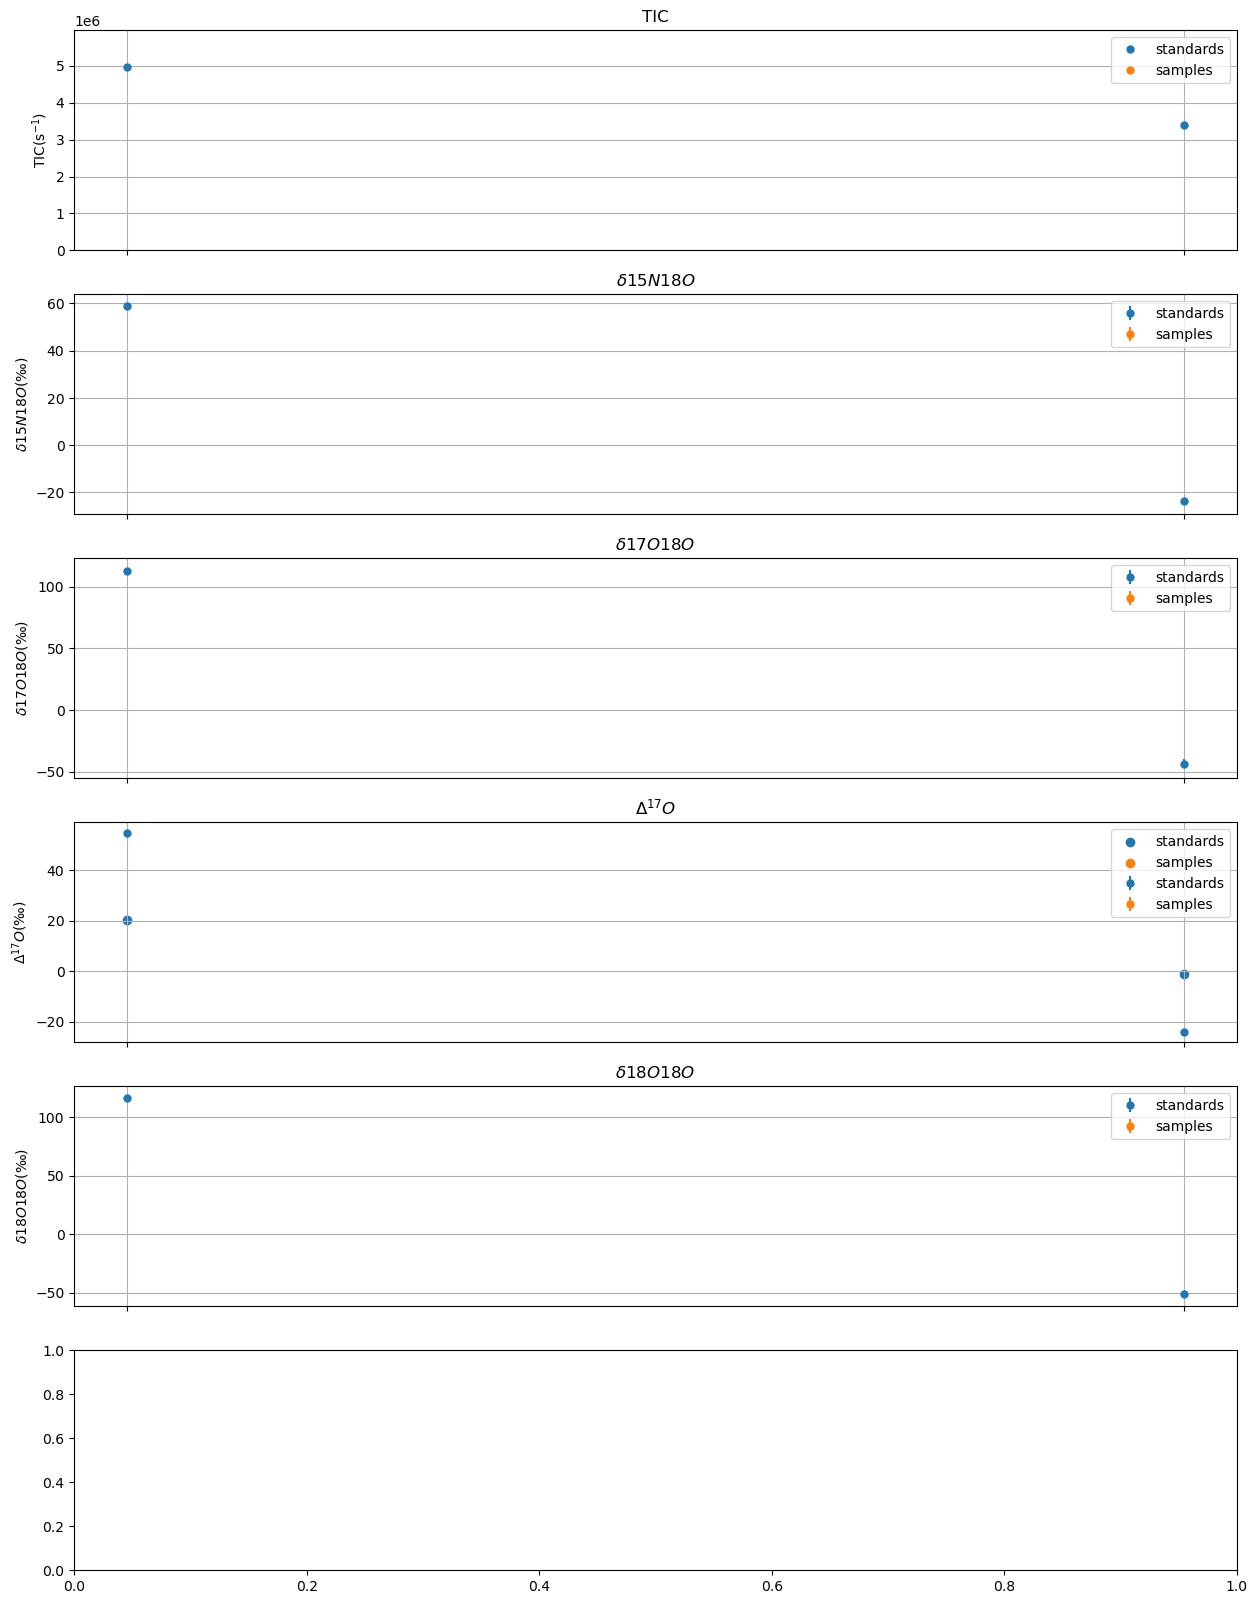

In [220]:
isotopologues_wo17 = [iso for iso in isotopologues if iso!='17O']

data = df_international_scale.copy()
data_spl = data.drop(index=[name for name in data.index if not name.startswith('C')])

fig,ax = plt.subplots(len(isotopologues_wo17)+2, figsize=[15,4*(len(isotopologues_wo17)+1)])

i=0
scatter = ax[i].errorbar([name for name in data.index], data['TIC_sample'],
                        linestyle='none',marker='o',ms=5,label='standards')
scatter = ax[i].errorbar([name for name in data_spl.index], data_spl['TIC_sample'],
                        linestyle='none',marker='o',ms=5,label='samples')
ax[i].grid(True, axis='both')
ax[i].set_ylabel('TIC(s$^{-1}$)')
ax[i].set_title('TIC')
ax[i].set_xticklabels([])
ax[i].set_ylim([0,1.2*max( data['TIC_sample'])])
ax[i].legend()

for ii,iso in enumerate(isotopologues_wo17):
    i=ii+1
    scatter = ax[i].errorbar([name for name in data.index], data['mean_d'+iso]*1000, yerr=data['err_d'+iso]*1000,
                            linestyle='none',marker='o',ms=5,label='standards')
    scatter = ax[i].errorbar([name for name in data_spl.index], data_spl['mean_d'+iso]*1000, yerr=data_spl['err_d'+iso]*1000,
                            linestyle='none',marker='o',ms=5,label='samples')
    ax[i].grid(True, axis='both')
    ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
    ax[i].set_title('$\delta' + iso +'$')
    ax[i].set_xticklabels([])
    ax[i].legend()
    
i=3
if '17O' in isotopologues and '18O' in isotopologues:
    D17 = data['mean_d17O']*1000 - 0.515* data['mean_d18O']*1000
    scatter = ax[i].scatter([name for name in data.index], D17,label='standards')
    D17 = data_spl['mean_d17O']*1000 - 0.515* data_spl['mean_d18O']*1000
    scatter = ax[i].scatter([name for name in data_spl.index], D17,label='samples')
    ax[i].grid(True, axis='both')
    ax[i].set_ylabel('$\Delta^{17}O$(‰)')
    ax[i].set_title('$\Delta^{17}O$')
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=90)
    ax[i].legend()

## 6. Save data to excel file

Saves results to the file specified in inputs, with each as a seperate sheet:
- Block average ratios, start/end times, #scans, median scan duration, average and std TIC and TICxIT
- Bracketed deltas before any correction
- Deltas after M0 correction
- Deltas after correction to international scale using value of internal standard (not calibrated)
- Summaries of mean and uncertainty of all bracketed deltas  

Note: saved delta values are not in permil


In [215]:
to_save = {'Block averages':summ,
           'Bracketed deltas':samples_delta,
           'Bracketed deltas summary':stats,
           'Referenced deltas summary':df_international_scale}

for sheet_name, df in to_save.items():
    # Check if the file exists
    if not os.path.exists(os.path.join(output_file)):
        # If the file doesn't exist, create a new ExcelWriter object without mode='a'
        with pd.ExcelWriter(os.path.join(output_file), engine='openpyxl') as writer:
            # Write the DataFrame to a new sheet with the specified sheet name
            df.to_excel(writer, sheet_name=sheet_name, index=True)
            print('Excel file created:',os.path.join(output_file),'\nNew sheet added to',output_file,':',sheet_name)
    else:
        # If the file exists, create an ExcelWriter object with mode='a' to append to the existing file
        with pd.ExcelWriter(os.path.join(output_file), engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
            # Write the DataFrame to a new sheet with the specified sheet name
            df.to_excel(writer, sheet_name=sheet_name, index=True)
            print('New sheet added to',output_file,':',sheet_name)

Excel file created: results_2024-09-16.xlsx 
New sheet added to results_2024-09-16.xlsx : Block averages
New sheet added to results_2024-09-16.xlsx : Bracketed deltas
New sheet added to results_2024-09-16.xlsx : Bracketed deltas summary
New sheet added to results_2024-09-16.xlsx : Referenced deltas summary
